# Pysaliency: A short tutorial

`pysaliency` is a python library which aims at making analyzing and modeling of eye movement data convenient. It was build and extended over the course of multiple papers which are reflected in its structure, mainly:

* [Kümmerer, Wallis & Bethge: Information-theoretic model comparison unifies saliency metrics. PNAS 2015](http://www.pnas.org/content/112/52/16054)
* [Kümmerer, Wallis & Bethge: Saliency Benchmarking Made Easy: Separating Models, Maps and Metrics. ECCV 2018](http://openaccess.thecvf.com/content_ECCV_2018/html/Matthias_Kummerer_Saliency_Benchmarking_Made_ECCV_2018_paper.html)
* [Kümmerer & Bethge: Predicting Visual Fixations, Annual Reviews in Vision Science 2023](https://www.annualreviews.org/doi/10.1146/annurev-vision-120822-072528)

In [1]:
import numpy as np
import os
from typing import Union

import matplotlib.pyplot as plt
import pysaliency

'''
MATLAB is needed to run the various processing scripts/model scripts
These were writen in MATLAB originally and the authors built Python 
wrappers to call them.
'''
os.environ['PATH'] = f'/software/matlab-R2023b/bin/:{os.environ["PATH"]}'

## Datasets

`pysaliency` has two main classes for handling data. `pysaliency.Stimuli` contains images which have been shown to a subject, `pysaliency.Fixations` keeps track of recorded fixations. For the purpose of this tutorial, we'll use the MIT1003 dataset, which `pysaliency` can download and import on it's own.

In [3]:
stimuli, fixations = pysaliency.get_mit1003(location='pysaliency_datasets')
# stimuli, fixations = pysaliency.get_cat2000_train(location='pysaliency_datasets', version='1.1')
# stimuli, fixations = pysaliency.external_datasets.coco_freeview.get_COCO_Freeview_train(location='pysaliency_datasets')

`Stimuli` hold the images in `Stimuli.stimuli` as numpy array. In the case of large datasets, the subclass `FileStimuli` (which is used here) will make sure that the images are only loaded once they are needed.

`Stimuli` also contain a list of filenames. Will be useful if we want to create torch datasets later. 

In [5]:
for image_index in range(10):
    print(f"{image_index:02d}: {stimuli.stimuli[image_index].shape} ({stimuli.filenames[image_index]})")

print(f"Total number of stimuli in dataset: {len(stimuli)}")

00: (768, 1024, 3) (pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010764.jpeg)
01: (768, 1024, 3) (pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010785.jpeg)
02: (768, 1024, 3) (pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010800.jpeg)
03: (768, 1024, 3) (pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010806.jpeg)
04: (768, 1024, 3) (pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010808.jpeg)
05: (768, 1024, 3) (pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010816.jpeg)
06: (768, 1024, 3) (pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010855.jpeg)
07: (768, 1024, 3) (pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010885.jpeg)
08: (768, 1024, 3) (pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010907.jpeg)
09: (768, 1024, 3) (pysaliency_datasets/MIT1003/stimuli/i10feb04_static_cars_highl

Plotting the stimuli

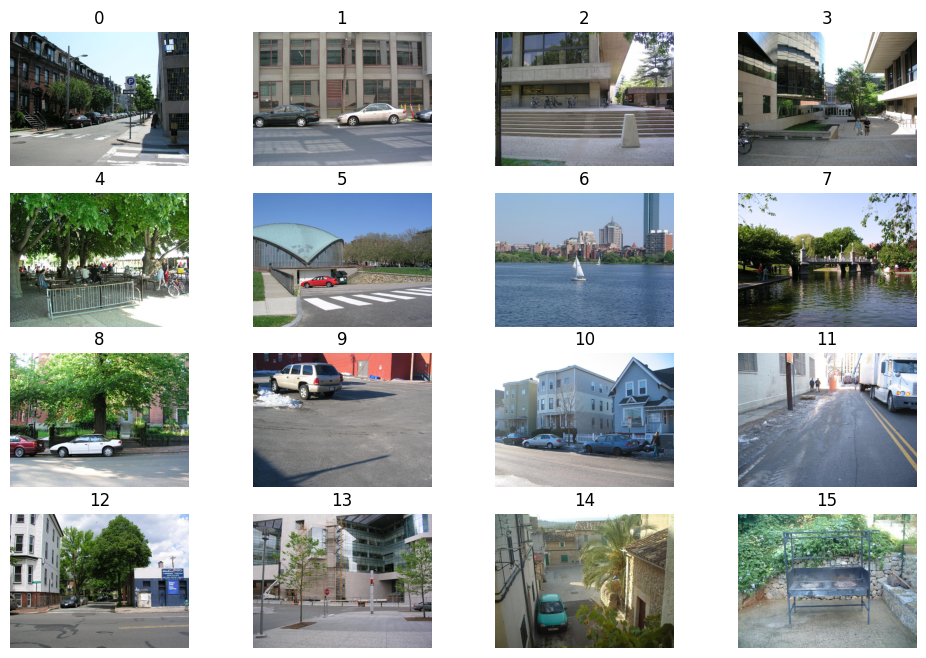

In [6]:
f, axes = plt.subplots(4, 4, figsize=(12, 8))

for k, ax in enumerate(axes.flatten()):
    ax.imshow(stimuli.stimuli[k])
    ax.set_axis_off()
    ax.set_title(str(k))

`Stimuli` instances implement the `collections.abs.Sequence` interface and hence behave mostly like normal lists, e.g. you can slice them with `stimuli[10:20]`.

In [9]:
sliced_stimuli = stimuli[3:5]
for i in range(len(sliced_stimuli)):
    print(sliced_stimuli.filenames[i])

pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010806.jpeg
pysaliency_datasets/MIT1003/stimuli/i05june05_static_street_boston_p1010808.jpeg


`Fixations` hold the fixations made on images. Fixations also behave mostly like a list, where each list item is a fixation made on an image. This also
holds for nearly all attributes, which are usually numpy arrays with one row per fixation. The most important attributes are `Fixations.x` and `Fixations.y` which
contain the x and y positions of the fixations in pixels. `Fixations` are always meant to be used together with a `Stimuli` object, where `Fixations.n` indicates for each fixation on which image it was made:

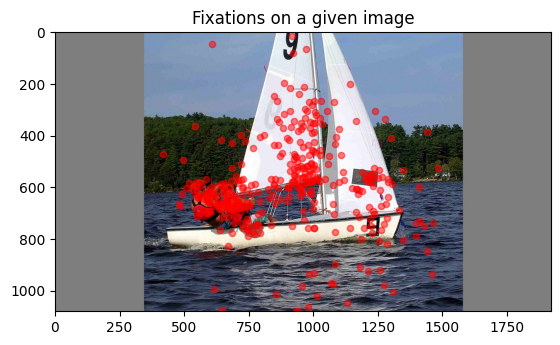

In [28]:
image_index = 42

plt.imshow(stimuli.stimuli[image_index])

fixation_indices = fixations.n == image_index
plt.scatter(fixations.x[fixation_indices], fixations.y[fixation_indices], 20, 'red', alpha=0.5)

plt.title("Fixations on a given image");

Just like `Stimuli`, `Fixations` support `len`, slicing and indexing. For example, the last cell could have
been written more elegantly as:

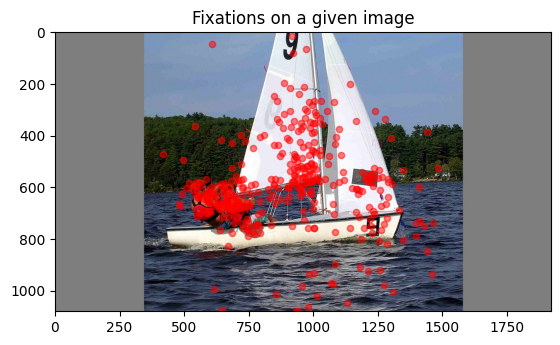

In [29]:
image_index = 42
image_fixations = fixations[fixations.n == image_index]

plt.imshow(stimuli.stimuli[image_index])
plt.scatter(image_fixations.x, image_fixations.y, 20, 'red', alpha=0.5)

plt.title("Fixations on a given image");

Fixations don't happen independently, they happen in sequences of so called *Scanpaths* and hence can depend on the previous fixations. Because of that,
for each fixation in a dataset, `Fixations` makes the previous fixations available via the attributes `Fixations.x_hist` and `Fixations.y_hist`.

In [30]:
fixation_index = 130

print(f"x, y position: ({fixations.x[fixation_index]}, {fixations.y[fixation_index]})")
print(f"number of previous fixations: {fixations.scanpath_history_length[fixation_index]}")
print(f"previous x locations: {fixations.x_hist[fixation_index]}")
print(f"previous y locations: {fixations.y_hist[fixation_index]}")

x, y position: (941.8, 517.8)
number of previous fixations: 2
previous x locations: [1075.7 1082.6]
previous y locations: [611.  614.1]


`pysaliency.plotting` contains some functions to make visualizing a fixation with its history easy:

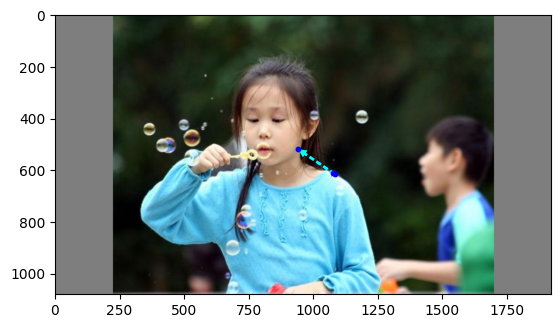

In [31]:
from pysaliency.plotting import plot_scanpath

plt.imshow(stimuli.stimuli[fixations.n[fixation_index]])
plot_scanpath(stimuli, fixations, fixation_index, visualize_next_saccade=True)

## ScanpathFixations

While for modeling, it often makes sense to think about each fixation separately, together with their respective history of previous fixations, when building datasets and doing analysis, it's also convenient to think about whole scanpaths. This is what `ScanpathFixations` is for: it's a `Fixations` subclass for fixations which come from scanpaths. Actually, the `fixations` object we worked with so far is such a case: It has an additional attribute `scanpaths` which holds a `Scanpaths` instance containing the actual scanpaths from which the Fixations instance has been build by concatenating the fixations from all scanpaths.

In [11]:
scanpaths = fixations.scanpaths
print(f"The dataset has {len(fixations)} fixations coming from a total of {len(scanpaths)} scanpaths")

The dataset has 104171 fixations coming from a total of 15045 scanpaths


`Scanpaths` as attributes `xs` and `ys` with the x and y locations of all fixations in a scanpath, and `length` containing the length of each scanpath.

In [12]:
rst = np.random.RandomState(seed=23)
scanpath_indices = rst.randint(len(fixations.scanpaths), size=3)

for scanpath_index in scanpath_indices:
    print(f"Scanpath no {scanpath_index}:")
    scanpath_length = scanpaths.length[scanpath_index]
    xs = scanpaths.xs[scanpath_index]
    ys = scanpaths.ys[scanpath_index]
    for k, (x, y) in enumerate(zip(xs, ys)):
        print(f"{k}: ({x:.01f}, {y:.01f})")
    print()

Scanpath no 8787:
0: (513.4, 278.4)
1: (329.6, 457.9)
2: (493.9, 550.8)
3: (496.7, 369.2)

Scanpath no 13030:
0: (530.1, 272.1)
1: (538.5, 372.4)
2: (254.4, 356.5)
3: (516.2, 234.0)
4: (290.6, 272.1)
5: (493.9, 150.6)
6: (546.8, 139.0)
7: (496.7, 337.5)
8: (410.4, 386.1)

Scanpath no 9256:
0: (622.0, 413.6)
1: (638.7, 586.8)
2: (148.6, 293.2)
3: (680.5, 428.4)
4: (505.0, 464.3)
5: (679.1, 410.4)
6: (920.0, 413.6)



In a `ScanpathFixations` instance, where the fixations come from scanpaths, the fixations have an additional attribute `scanpath_index`, which allows to got back from individual fixations to the scanpaths:

In [13]:
scanpath_index = scanpath_indices[0]
fixation_indices = fixations.scanpath_index == scanpath_index

print(fixations.x[fixation_indices])
print(fixations.y[fixation_indices])

[513.39240506 329.59493671 493.89873418 496.6835443 ]
[278.4   457.92  550.848 369.216]


### Filtering fixations

One might ask: why separating between `ScanpathFixations` and `Fixations` in the first place? After all, fixations always come from scanpaths.
The main reason is there are many case where we are only interested in some fixations, but need to be aware of the full scanpath
history for each of those fixations. One very important case is that in most experiments, the first fixation is not a voluntary fixation, but a forced central fixation.
There is no point in modeling and predicting this fixation, or including it in evaluating models. But of course when predicting the later, voluntary fixations, models need to be aware of the initial central fixation. In this case, we can easily filter a `ScanpathFixations` instance (or a `Fixations` instance) accordingly:

In [14]:
# filter fixations to exclude initial fixations from each scanpath
voluntary_fixations = fixations[fixations.scanpath_history_length > 0]

# show first three fixations
for fixation_index in range(3):
    x_pos = voluntary_fixations.x[fixation_index]
    x_hist = voluntary_fixations.x_hist[fixation_index]
    print(f"{fixation_index}: {x_pos:.01f}, previous x positions: {x_hist}")

0: 674.9, previous x positions: [502.25316456]
1: 686.1, previous x positions: [502.25316456 674.91139241]
2: 505.0, previous x positions: [502.25316456 674.91139241 686.05063291]


We can see that the original initial fixation at x=502.3 is included in the history of all subsequent fixations, but it's not a fixation in the `Fixations` instance on its own.

Similarly, we can filter `Fixations` and `ScanpathFixations` instances according to other attribute. One important attribute is `subject`, which encodes
the id of the subject which made a certain fixation:

In [15]:
print(fixations.subject)

[ 0  0  0 ... 14 14 14]


With this attribute, we can easily select all fixations from any given subject:

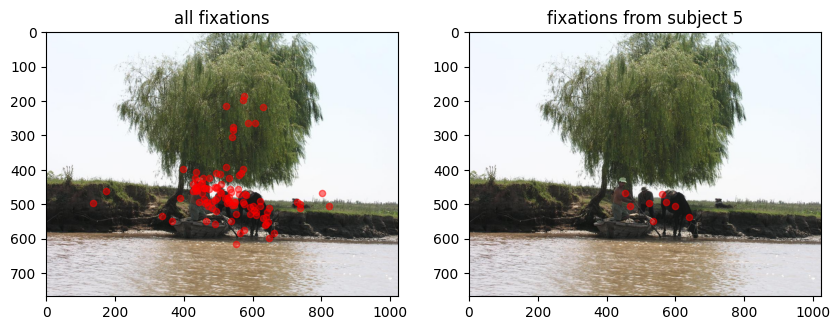

In [16]:
subject_id = 5

subject_fixations = fixations[fixations.subject == subject_id]

image_index = 42
image_fixations = fixations[fixations.n == image_index]
image_subject_fixations = subject_fixations[subject_fixations.n == image_index]


f, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(stimuli.stimuli[image_index])
axs[0].scatter(image_fixations.x, image_fixations.y, 20, 'red', alpha=0.5)
axs[0].set_title("all fixations");

axs[1].imshow(stimuli.stimuli[image_index])
axs[1].scatter(image_subject_fixations.x, image_subject_fixations.y, 20, 'red', alpha=0.5)
axs[1].set_title(f"fixations from subject {subject_id}");

### Attributes

`Fixations` instances can have more attributes besides `x`, `y`, `t`, `{x,y,t}_hist` and `subject`. We can check `Fixations.__attributes__` to see all available attributes (this will probably change in a future version a bit). In the case of the MIT1003 dataset, we also have information about fixation durations and the duration of previous fixations:

In [17]:
print("all attributes:", fixations.__attributes__)

all attributes: ['subject', 'scanpath_index', 'duration', 'duration_hist']


## Models

Pysaliency's main modeling framework is that of probabilistic models, where a model predicts fixations via the means of a probability distribtion (see, e.g. Kümmerer & Bethge 2023). For predicting spatial fixation densities, pysaliency uses the class `Model`, which needs to implement a function `_log_density` for computing a predicted log density. This is an example for a simple model, which predicts fixations to be distributed according to a central Gaussian:

In [18]:
class MySimpleModel(pysaliency.Model):
    def __init__(self, width=0.5, **kwargs):
        super().__init__(**kwargs)
        self.width = width

    def _log_density(self, stimulus: Union[pysaliency.datasets.Stimulus, np.ndarray]):
        # _log_density can either take pysaliency Stimulus objects, or, for convenience, simply numpy arrays
        # `as_stimulus` ensures that we have a Stimulus object
        stimulus_object = pysaliency.datasets.as_stimulus(stimulus)

        # size contains the height and width of the image, but not potential color channels
        height, width = stimulus_object.size

        xs = np.arange(width, dtype=float)
        ys = np.arange(height, dtype=float)
        XS, YS = np.meshgrid(xs, ys)

        XS -= 0.5 * width
        YS -= 0.5 * height

        max_size = max(width, height)
        actual_kernel_size = self.width * max_size

        gaussian = np.exp(-0.5 * (XS ** 2 + YS ** 2) / actual_kernel_size ** 2)
        
        density = gaussian / gaussian.sum()
        return np.log(density)

my_simple_model = MySimpleModel(width=0.2)

When using the model, we use the function `log_density`, which mainly adds a cache around `_log_density` to avoid recomputing log densities multiple times. This is how the resulting prediction looks like:

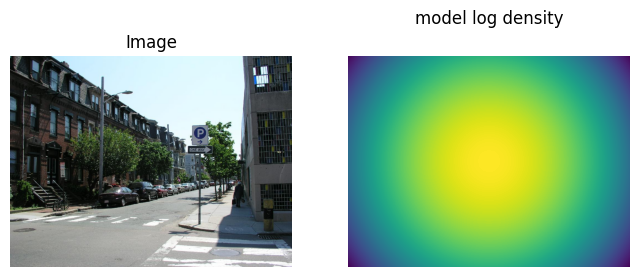

In [19]:
from pysaliency.plotting import visualize_distribution

f, axs = plt.subplots(1, 2, figsize=(8, 5))

image_index = 0

axs[0].imshow(stimuli.stimuli[image_index])
axs[0].set_axis_off()
axs[0].set_title("Image")

axs[1].matshow(my_simple_model.log_density(stimuli[image_index]))
axs[1].set_axis_off()
axs[1].set_title("model log density");

pysaliency comes with a range of fixation models for comparision, for example [DeepGaze I](http://arxiv.org/abs/1411.1045)

In [20]:
# deepgaze needs a spatial prior, for which we use our Gaussian model here
deepgaze1_model = pysaliency.external_models.DeepGazeI(centerbias_model=my_simple_model)

/home/nisar2/datasets/saliency-datasets/pysaliency/env/lib/python3.11/site-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/matthias-k/DeepGaze/zipball/main" to /home/nisar2/.cache/torch/hub/main.zip
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /home/nisar2/.cache/torch/hub/v0.6.0.zip
/home/nisar2/datasets/saliency-datasets/pysaliency/env/lib/python3.11/site-packages/torchvisi

Because visualizing densities is nontrivial, `pysaliency.plotting` contains the function `visualize_distribution`
to get a nice visualization (for details check Figure 5 in the appendix of https://arxiv.org/abs/1704.08615)

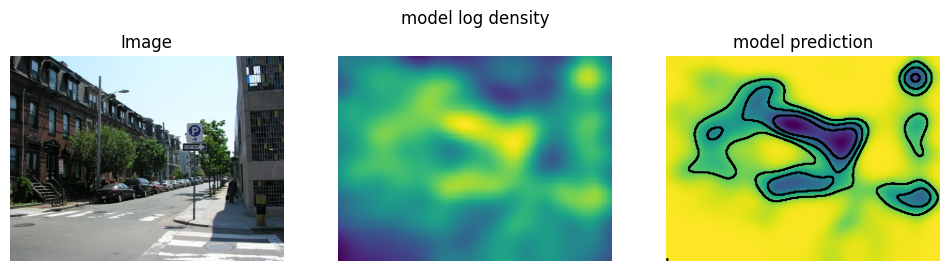

In [21]:
from pysaliency.plotting import visualize_distribution

f, axs = plt.subplots(1, 3, figsize=(12, 8))

image_index = 0

axs[0].imshow(stimuli.stimuli[image_index])
axs[0].set_axis_off()
axs[0].set_title("Image")

axs[1].matshow(deepgaze1_model.log_density(stimuli[image_index]))
axs[1].set_axis_off()
axs[1].set_title("model log density")

visualize_distribution(deepgaze1_model.log_density(stimuli[image_index]))
axs[2].set_axis_off()
axs[2].set_title("model prediction");

Probabilistic models allow for straight forward sampling of new fixations:

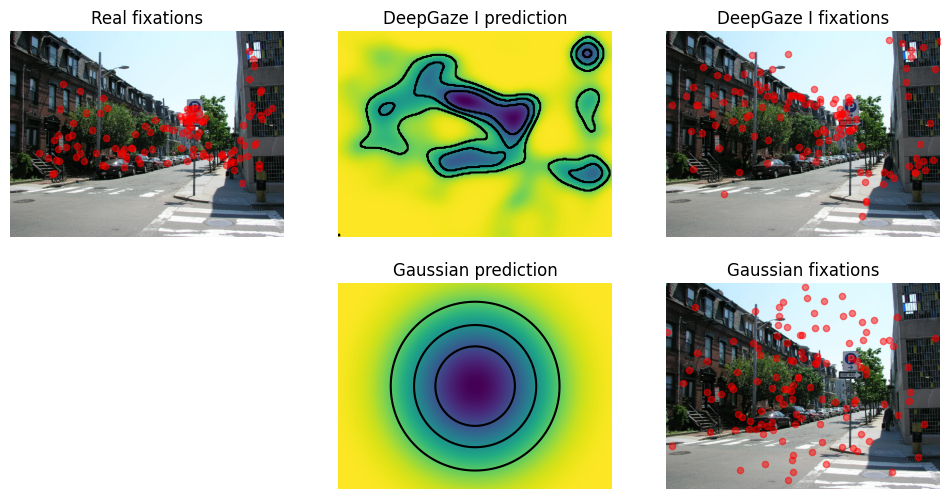

In [22]:
# sample 120 new fixations (or, more precisely, scanpaths of length 1):
rst = np.random.RandomState(42)  # pysaliency allows to specify the random state for deterministic behaviour
actual_fixations = fixations[fixations.n == 0]
new_fixations_gaussian = my_simple_model.sample(stimuli[:1], train_counts=120, lengths=1, rst=rst)
new_fixations_deepgaze = deepgaze1_model.sample(stimuli[:1], train_counts=120, lengths=1, rst=rst)



f, axs = plt.subplots(2, 3, figsize=(12, 6))

axs[0, 0].imshow(stimuli.stimuli[0])
axs[0, 0].scatter(actual_fixations.x, actual_fixations.y, 20, 'red', alpha=0.5)
axs[0, 0].set_title("Real fixations")

visualize_distribution(deepgaze1_model.log_density(stimuli[0]), ax=axs[0, 1])
axs[0, 1].set_title("DeepGaze I prediction")
axs[0, 2].imshow(stimuli.stimuli[0])
axs[0, 2].scatter(new_fixations_deepgaze.x, new_fixations_deepgaze.y, 20, 'red', alpha=0.5)
axs[0, 2].set_title("DeepGaze I fixations")

visualize_distribution(my_simple_model.log_density(stimuli[0]), ax=axs[1, 1])
axs[1, 2].imshow(stimuli.stimuli[0])
axs[1, 1].set_title("Gaussian prediction")
axs[1, 2].scatter(new_fixations_gaussian.x, new_fixations_gaussian.y, 20, 'red', alpha=0.5)
axs[1, 2].set_title("Gaussian fixations")


for ax in axs.flatten():
    ax.set_axis_off()

## Scanpath models

As already mentioned, fixation usually depend on previous fixation locations. Scanpath models aim at incorporating these dependencies. As discussed in [Kümmerer & Bethge: Predicting Visual Fixations, Annual Reviews in Vision Science 2023](https://www.annualreviews.org/doi/10.1146/annurev-vision-120822-072528) in detail, "next-fixation-prediction" is a powerful way to unify many different gaze prediction settings including scanpath prediction and spatial density prediction. The key idea is to not model whole scanpaths at once, but instead for each fixation in a scanpath predict a probability distribution of possible next fixation locations given the previous fixations, that is:

$$
  p(x_{i+1}, y_{i+1} \mid x_0, y_0, \dots, x_{i}, y_{i}, I)
$$

In the case of spatial gaze density prediction as above, e.g. using DeepGaze I, the dependency on previous fixations is not used and the model prediction for the next fixation is simply the predicted gaze density:

$$
  p(x_{i+1}, y_{i+1} \mid x_0, y_0, \dots, x_{i}, y_{i}, I) \stackrel{\text{density prediction}}{=} p(x, y \mid I)
$$

Pysaliency provides the class `ScanpathModel` for modeling scanpaths. Instead of implementing `_log_density`, now we need to implement `conditional_log_density(stimulus, x_hist, y_hist)`:

In [23]:
from pysaliency.utils import remove_trailing_nans

class MySimpleScanpathModel(pysaliency.ScanpathModel):
    def __init__(self, prior_width: float=0.3, saccade_width: float=0.2):
        self.prior_width = prior_width
        self.saccade_width = saccade_width

    def conditional_log_density(self, stimulus, x_hist, y_hist, t_hist, attributes=None, out=None,):
        stimulus_object = pysaliency.datasets.as_stimulus(stimulus)

        # size contains the height and width of the image, but not potential color channels
        height, width = stimulus_object.size

        # compute prior
            
        xs = np.arange(width, dtype=float)
        ys = np.arange(height, dtype=float)
        XS, YS = np.meshgrid(xs, ys)

        XS -= 0.5 * width
        YS -= 0.5 * height

        max_size = max(width, height)
        actual_kernel_size = self.prior_width * max_size

        prior_gaussian = np.exp(-0.5 * (XS ** 2 + YS ** 2) / actual_kernel_size ** 2)

        # compute saccade bias

        last_x = x_hist[-1]
        last_y = y_hist[-1]
        
        xs = np.arange(width, dtype=float)
        ys = np.arange(height, dtype=float)
        XS, YS = np.meshgrid(xs, ys)

        XS -= last_x
        YS -= last_y

        max_size = max(width, height)
        actual_kernel_size = self.saccade_width * max_size

        saccade_bias = np.exp(-0.5 * (XS ** 2 + YS ** 2) / actual_kernel_size ** 2)

        prediction = prior_gaussian * saccade_bias
        
        density = prediction / prediction.sum()
        return np.log(density)

my_simple_scanpath_model = MySimpleScanpathModel()

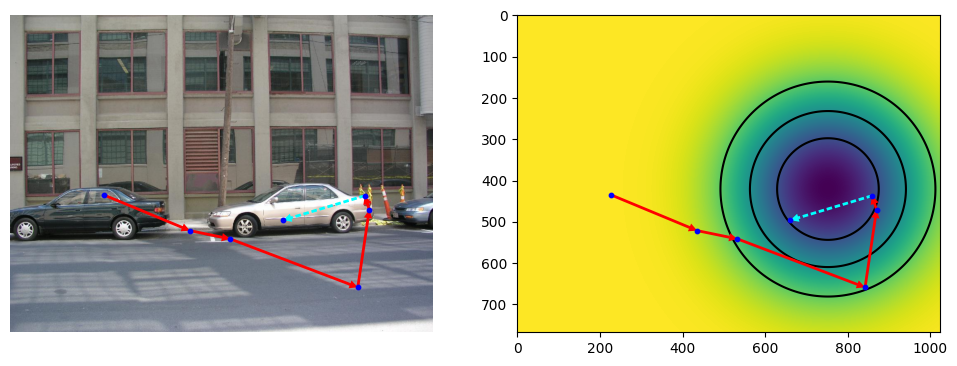

In [24]:
fixation_index = 130

f, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(stimuli.stimuli[fixations.n[fixation_index]])
plot_scanpath(stimuli, fixations, fixation_index, visualize_next_saccade=True, ax=axs[0])
axs[0].set_axis_off()

prediction = my_simple_scanpath_model.conditional_log_density(
    stimuli.stimuli[fixations.n[fixation_index]],
    x_hist=fixations.x_hist[fixation_index],
    y_hist=fixations.y_hist[fixation_index],
    t_hist=None,
)

visualize_distribution(prediction, ax=axs[1])
plot_scanpath(stimuli, fixations, fixation_index, visualize_next_saccade=True, ax=axs[1])

Since computing the conditional log density for a given fixation in a dataset is a very common task, `ScanpathModel` provides
the convenience method `conditional_log_density_for_fixation(stimuli, fixations, fixation_index)` to that end. Using it, we
could also have written:

In [ ]:
prediction = my_simple_scanpath_model.conditional_log_density_for_fixation(
    stimuli,
    fixations,
    fixation_index=fixation_index,
)

## Evaluating models


Pysaliency incorporates extensive mechanisms for evaluationg model performances. For probabilistic models, i.e., instances of `pysaliency.Model` and `pysaliency.ScanpathModel`, pysaliency makes it simple to compute log-likelihood and information gain scores ([Kümmerer et al, PNAS 2015](http://www.pnas.org/content/112/52/16054), [Kümmerer & Bethge, Ann.Rev.Vis.Sci 2023](https://www.annualreviews.org/doi/10.1146/annurev-vision-120822-072528)). Other popular metrics like AUC, CC etc can also be computed as we'll see below by using the methods from [Kümmerer et al, ECCV 2018](http://openaccess.thecvf.com/content_ECCV_2018/html/Matthias_Kummerer_Saliency_Benchmarking_Made_ECCV_2018_paper.html).

Information gain is the difference in log-likelihood between a model and a baseline model:

$$
  IG(\hat p, p_\text{baseline}) = \log \hat p(x_i, y_i) - \log p_\text{baseline}(x_i, y_i)
$$

The model method `information_gains` computes information gain values for each fixation:

In [ ]:
# we want to exclude the initial fixation from evaluation
eval_fixations = fixations[fixations.scanpath_history_length > 0]

# we only want to evaluate the first 20 fixations
eval_fixations = eval_fixations[:20]
deepgaze1_model.information_gains(stimuli, eval_fixations, verbose=False)

By default, `information_gains` uses a uniform baseline model, but we can hand over any other model. Often, it makes sense
to use a center bias model as prior, in which case the name "information gain" is actually justified.

Often we're only interested in average performance over a full dataset. In this case, we can use the method `information_gain` instead of `information_gains`
which takes care of the averaging. Since we want each image to contribute equally to the score, we'll use `average='image'`. By default each fixation contributes equally (`average='fixations').

In [ ]:
print("information gain relative to a uniform baseline model   ", deepgaze1_model.information_gain(stimuli, eval_fixations, average='image'))
print("information gain relative to a centerbias baseline model", deepgaze1_model.information_gain(stimuli, eval_fixations, baseline_model=my_simple_model, average='image'))

One advantage of the framework of next-fixation-prediction is that it allows easy comparison of spatial models and scanpath models:

In [ ]:
print("Simple Scanpath Model: IG =", my_simple_scanpath_model.information_gain(stimuli, eval_fixations, verbose=False, average='image'))
print("DeepGaze I:            IG =", deepgaze1_model.information_gain(stimuli, eval_fixations, verbose=False, average='image'))

We can see that in this case the better understanding of image-based effects of DeepGaze I outweights the additional dynamics of the simple scanpath model

## Saliency Map Models

Traditionally, the field of fixation prediction mainly formulated their models as so called *saliency models*. Saliency models predict fixation locations by the means of a *saliency map*, where areas of high saliency are expected to have more fixations. The reason for this somewhat vague definition has historical reasons, see [Kümmerer & Bethge, Ann.Rev.Vis.Sci 2023](https://www.annualreviews.org/doi/10.1146/annurev-vision-120822-072528).

Pysaliency uses the class `pysaliency.SaliencyMapModel` to implement saliency map models. They behave very similarly to the `Model` class, but instead of methods `log_density` and `_log_density`, they have methods `saliency_map` and `_saliency_map` with identical signature. Pysaliency comes with a range of published saliency models prewrapped, we'll use the [AIM](https://jov.arvojournals.org/article.aspx?articleid=2193531) model here as an example. Most saliency models are implemented in matlab and hence require matlab to run. Pysaliency will automatically download the original source code, potentially apply some patches to make it run in more modern matlab versions and then call matlab as part of the `_saliency_map` method:

In [ ]:
aim_model = pysaliency.AIM(location='pysaliency_models')

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12, 5))

image_index = 0

axs[0].imshow(stimuli.stimuli[image_index])
axs[0].set_axis_off()
axs[0].set_title("Image")

axs[1].matshow(aim_model.saliency_map(stimuli[image_index]))
axs[1].set_axis_off()
axs[1].set_title("AIM saliency map");

Saliency map models don't allow information theoretic evaluation with information gain. Instead, a multitude of different saliency metrics has been proposed. Pysaliency implements many of the common metrics, such as AUC, sAUC, NSS, CC, SIM and KL-Div as methods of `pysaliency.SaliencyMapModel`:

In [ ]:
print(f"AUC: {aim_model.AUC(stimuli, eval_fixations, average='image'):.04f}")

### Saliency metric score for probabilistic models

`Model` and `ScanpathModel` don't support saliency metrics as AUC and CC directly, because it's not clear what to use as saliency map for the metric
and indeed for different metrics different saliency maps are optimal ([Kümmerer et al, ECCV 2018](http://openaccess.thecvf.com/content_ECCV_2018/html/Matthias_Kummerer_Saliency_Benchmarking_Made_ECCV_2018_paper.html)). Before computing saliency metrics, probabilistic models have to be converted to saliency map models. For AUC, we can simply use predicted fixation density as saliency map (but for other metrics, much more complicated maps might be appropriate):

In [ ]:
deepgaze1_density_map_model = pysaliency.DensitySaliencyMapModel(deepgaze1_model)
print(f"DeepGaze AUC: {deepgaze1_density_map_model.AUC(stimuli, eval_fixations, average='image'):.04f}")